<a href="https://colab.research.google.com/github/naiaragama/SoulCode-Engenharia-de-Dados/blob/main/Projeto-Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


* PROJETO FINAL

Este projeto tem como objetivo a realização de um processo de ETL (extração, transformação, carregamento) que consolide algumas bases de dados sobre o mercado automotivo no Brasil, as bases originais podem ser encontradas clicando nesses nos links: [aqui](https://www.kaggle.com/datasets/vagnerbessa/average-car-prices-bazil) [aqui](https://www.alphacast.io/datasets/activity-brazil-anfavea-automotive-production-and-sales-6654)


Fizemos pesquisa e encontarmos uma base com dados da Fundação Instituto de Pesquisas Econômicas (FIPE) em formato CSV e outra base com dados da Associação Nacional dos Fabricantes de Veículos Automotores (ANFAVEA) em formato XLSX.


Realizamos as análises e tratamento do arquivo CSV no Pandas e o outro arquivo XLSX no Pyspark.


Salvamos os datasets em armazenamento Cloud dentro da plataforma GCP.


Os dados tratados estão no datalake (Gstorage ) e DW (BigQuery).


Utilizando a linguagem padrão SQL para as análises dentro do Big Query e estão com a descrição das consultas.


Criamos um dashboard no Looker Studio para exibição gráfica dos dados tratados com alguns insights.


O workflow com as etapas de ETL e as ferramentas utilizadas está em nossa apresentação no Looker Studio.



* MYSQL


O armazenamento de um dos dataset está no MySQL. Colocamos o dataset da tabela Fipe com sucesso. O segundo dataset não conseguimos, pois o dataset mesmo após renomeado continuava com muitos caracteres no nome das colunas e o MySQL tem um limite. Por orientação do mentor não subimos o segundo dataset pois já tínhamos subido o primeiro.



* MONGO


Os Dataframes estão em uma coleção do mongoDb Atlas (X509-cert-1524735985430801619.pem).



* CUSTOS COM GOOGLE CLOUD

Nosso custo com o Google Cloud no período do projeto foi de R$ 123,00.
Utilizamos as configurações com menor custo como por exemplo escolhemos uma única região. 



# Instalações

In [ ]:
!pip install pyspark
!pip install gcsfs
!pip install mysql-connector-python
!pip install PyMySQL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=c423cd61f25721466ed40c9d9372560edf49f02e6d9a332cba37d1c131edcc87
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 49.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━

Importações



In [ ]:
import pymongo 
import os
import pandas as pd
import numpy as np
import mysql.connector
import datetime
import pyspark

In [ ]:
from pymongo import MongoClient
from google.cloud import storage
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import NullType
from mysql.connector import Error
from sqlalchemy import create_engine
from pyspark.sql.types import StructType, StringType, StructField
from pyspark.sql.functions import split
from pyspark.sql.functions import regexp_replace, split
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import  FloatType, LongType, DateType, TimestampType

# Extração das bases de dados 

# CloudStorage

In [ ]:
#Configuração da chave de segurança
serviceAccount = '/content/nkvs-consultoria-373916-4a1e41096722.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

Envio DFs originais para GCS

In [ ]:
#Função para fazer upload de arquivo no bucket
def upload_blob(bucket, arquivo, destino):
    client = storage.Client()
    bucket = client.bucket(bucket)
    blob = bucket.blob(destino)

    blob.upload_from_filename(arquivo)

    print(
        f"Arquivo {arquivo} foi upado em {destino}."
    )

In [ ]:
#Upload para bucket arquivo original 1
bucket = 'bc26_projeto_final_auto'
arquivo = '/content/fipe_2022.csv'
destino = 'original/fipe_2022.csv'
upload_blob(bucket, arquivo, destino)

Arquivo /content/fipe_2022.csv foi upado em original/fipe_2022.csv.


In [ ]:
#Upload para bucket arquivo original 2
bucket = 'bc26_projeto_final_auto'
arquivo = '/content/dados_brasil.xlsx'
destino = 'original/dados_brasil.xlsx'
upload_blob(bucket, arquivo, destino)

Arquivo /content/dados_brasil.xlsx foi upado em original/dados_brasil.xlsx.


In [ ]:
#Carregando dfs para pandas para confirmar a transferência 
df1 = pd.read_excel('gs://bc26_projeto_final_auto/original/dados_brasil.xlsx')

In [ ]:
df2 = pd.read_csv('gs://bc26_projeto_final_auto/original/fipe_2022.csv')

In [ ]:
# setando configurações de display do pandas
pd.set_option('display.max_columns',50)
#pd.set_option('display.max_rows')

In [ ]:
#backup
df1back = df1.copy()

In [ ]:
#backup
df1back = df2.copy()

# Análise do Dataset - Fipe 2022

In [ ]:
df2

In [ ]:
df2.dtypes

In [ ]:
df2.isna().sum()

In [ ]:
df2.duplicated().sum()

1

## Renomear e traduzir colunas e linhas

In [ ]:
#Tradução do nome das colunas
df2.rename(columns={'year_of_reference':'ano_referencia',
                     'month_of_reference':'mes_referencia',
                     'fipe_code':'codigo_fipe',
                     'authentication':'autenticacao',
                     'brand':'marca',
                     'model':'modelo',
                     'fuel':'combustivel',
                     'gear':'cambio',
                     'engine_size':'tamanho_motor',
                     'year_model':'ano_modelo',
                     'avg_price_brl':'preco_medio_reais',
                     'age_years':'anos_idade'
                    }, inplace=True)

In [ ]:
df2.head(3)

##Traduzindo e renomeando Linhas das Colunas

In [ ]:
df2["combustivel"] = df2["combustivel"].replace("Gasoline", "Gasolina")

In [ ]:
df2["combustivel"] = df2["combustivel"].replace("Alcohol", "Alcool")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("January", "Janeiro")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("February", "Fevereiro")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("March", "Março")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("April", "Abril")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("May", "Maio")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("June", "Junho")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("July", "Julho")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("August", "Agosto")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("October", "Outubro")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("September", "Setembro")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("November", "Novembro")

In [ ]:
df2["mes_referencia"] = df2["mes_referencia"].replace("December", "Dezembro")

In [ ]:
df2['cambio'] = df2['cambio'].replace('automatic', 'automatico')

In [ ]:
df2

In [ ]:
df2.head(3)

#Verificando as inconsistências

com sorted e unique


In [ ]:
sorted(pd.unique(df2['ano_referencia']))

In [ ]:
sorted(pd.unique(df2['mes_referencia']))

In [ ]:
sorted(pd.unique(df2['marca']))

In [ ]:
sorted(pd.unique(df2['modelo']))

In [ ]:
sorted(pd.unique(df2['combustivel']))

In [ ]:
sorted(pd.unique(df2['cambio']))

In [ ]:
sorted(pd.unique(df2['tamanho_motor']))

In [ ]:
sorted(pd.unique(df2['ano_modelo']))

In [ ]:
sorted(pd.unique(df2['preco_medio_reais']))



## Colunas sem inconsistências

In [ ]:
pd.unique(df2['ano_referencia'])

In [ ]:
pd.unique(df2['mes_referencia'])

In [ ]:
pd.unique(df2['modelo'])

In [ ]:
pd.unique(df2['combustivel'])

In [ ]:
pd.unique(df2['cambio'])

In [ ]:
pd.unique(df2['tamanho_motor'])

In [ ]:
pd.unique(df2['ano_modelo'])

In [ ]:
pd.unique(df2['ano_modelo'])

In [ ]:
pd.unique(df2['preco_medio_reais'])

array([43779., 42244., 40841., ..., 72474., 67040.,    nan])

##Dropando as Colunas

Bloco com recuo

In [ ]:
#Drop de colunas que não serão utilizadas
df2.drop(['codigo_fipe', 'autenticacao'],axis=1,inplace=True)

In [ ]:
df2.head()

#Filtros

In [ ]:
df2.head(3)

In [ ]:
#Filtro para visualizar a marca dos carros
filtrocarros = df2.marca == 'Fiat'
df2.loc[filtrocarros]

In [ ]:
#Filtro do ano de modelo dos carros
ftanomodelo = df2.ano_modelo == 2022
df2.loc[ftanomodelo]

In [ ]:
#Filtro por ano de referência da tabela Fipe
ftanoreferencia = df2.ano_referencia == 2022
df2.loc[ftanoreferencia]

In [ ]:
#Relacionando os Filtros
df2.loc[filtrocarros & ftanomodelo & ftanoreferencia]

#Groupby

In [ ]:
df2.head(3)

,ano_referencia,mes_referencia,marca,modelo,combustivel,cambio,tamanho_motor,ano_modelo,preco_medio_reais,anos_idade
0,2022,Janeiro,Acura,NSX 3.0,Gasolina,manual,3.0,1995.0,43779.0,28.0
1,2022,Janeiro,Acura,NSX 3.0,Gasolina,manual,3.0,1994.0,42244.0,29.0
2,2022,Janeiro,Acura,NSX 3.0,Gasolina,manual,3.0,1993.0,40841.0,30.0


In [ ]:
#Agrupando por capacidade de motor
df2.groupby(['tamanho_motor']).size().sort_values(ascending=False)

In [ ]:
#Agrupando pelo mês de referência
df2.groupby(['mes_referencia']).size().sort_values(ascending=False) 

In [ ]:
#Agrupando pelas marcas
df2.groupby(['marca']).size().sort_values(ascending=False)

#Plotagem


In [ ]:
df2.head(3)

,ano_referencia,mes_referencia,marca,modelo,combustivel,cambio,tamanho_motor,ano_modelo,preco_medio_reais,anos_idade
0,2022,Janeiro,Acura,NSX 3.0,Gasolina,manual,3.0,1995.0,43779.0,28.0
1,2022,Janeiro,Acura,NSX 3.0,Gasolina,manual,3.0,1994.0,42244.0,29.0
2,2022,Janeiro,Acura,NSX 3.0,Gasolina,manual,3.0,1993.0,40841.0,30.0


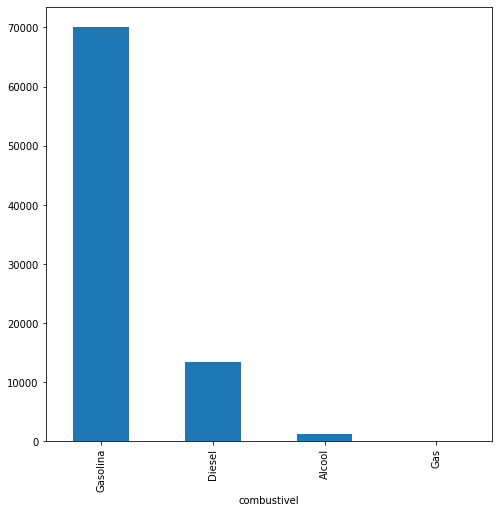

In [ ]:
#Combustível mais utilizado
df2.groupby(['combustivel'],dropna=False).size().sort_values(ascending=False).head(5).plot.bar(figsize=(8,8)) 

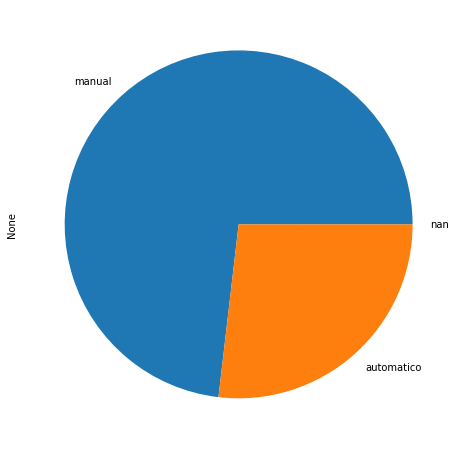

In [ ]:
#Número maior de carros com câmbio manual
df2.groupby(['cambio'],dropna=False).size().sort_values(ascending=False).plot.pie(figsize=(8,8))

# Dataset fipe_2022 tratado enviando para bucket

In [ ]:
#Upload
client = storage.Client()             
bucket = client.get_bucket('')

blob = bucket.blob('')
blob.upload_from_filename('')  

In [ ]:
dados_fipe_final = df2

In [ ]:
dados_fipe_final

In [ ]:
dados_fipe_final.to_csv('dadoss_finais.csv')

In [ ]:
#Carregando arquivos
client=storage.Client();
bucket=client.get_bucket('bc26_projeto_final');
blob=bucket.blob('tratados/dadoss_finais.csv')
blob.upload_from_filename('/content/dadoss_finais.csv')

#MongoDB

In [ ]:
#conector do mongo atlas
uri = "mongodb://ac-wrb5fxy-shard-00-00.afy6vc5.mongodb.net:27017,ac-wrb5fxy-shard-00-01.afy6vc5.mongodb.net:27017,ac-wrb5fxy-shard-00-02.afy6vc5.mongodb.net:27017/?ssl=true&replicaSet=atlas-atmqzb-shard-0&authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client_1 = MongoClient(uri, tls=True, tlsCertificateKeyFile='/content/X509-cert-1524735985430801619.pem')

In [ ]:
#coleção dados da Fipe
db = client_1['Projeto']
colecao = db['FIPE-2022']

In [ ]:
doc_count = colecao.count_documents({})
print(doc_count)

In [ ]:
# enviar o DF para colecao selecionada no mongo
df2_dict = df2.to_dict("records")
colecao.insert_many(df2_dict)

In [ ]:
# escolha/crie o database e colecao
db = client_1['Projeto']
colecao = db['dadoss_finais']

In [ ]:
dados_fipe_final_dict = dados_fipe_final.to_dict("records")
colecao.insert_many(dados_fipe_final_dict)

In [ ]:
colec = colecao.find({})
dados_fipe = pd.DataFrame(list(colec))

In [ ]:
colecao.count_documents({})

In [ ]:
dados_fipe

In [ ]:
df3 = pd.read_csv('/content/dados_brasil_consolidado.csv')

In [ ]:
#coleção dados dataframe Brasil
db2 = client_1['Projeto']
colecao2 = db2['dados_brasil_consolidado']

In [ ]:
doc_count = colecao2.count_documents({})
print(doc_count)

0


In [ ]:
# enviar o DF para colecao selecionada no mongo
df3_dict = df3.to_dict('records')
colecao2.insert_many(df3_dict)

In [ ]:
colec_2 = colecao2.find({})
dados_brasil = pd.DataFrame(list(colec_2))

In [ ]:
colecao2.count_documents({})

59

In [ ]:
dados_brasil

,_id,data,vendas_saz,vendas_saz_preco_mes,vendas_saz_preco_ano,prod_auto_leve,prod_auto_leve_preco_atual_mes,prod_auto-leve_ano,expo_saz,expo_saz_preço_mes,...,vendas_preco_ano,vendas_sa,vendas_sa_mes,expo_auto,expo_preco_mes,expo_preco_ano,vendas_total,vendas_total_preco_mes,vendas_total_sa_mes,ano
0,63c6b388557ee47cb29f0341,2021-08-01,141804.0,-4.51,-13.98,148857.0,0.70,-26.15,28721.0,23.26,...,-9.71,133875.44,-8.56,29444.0,23.89,5.55,178900.0,2.38,-5.31,2021
1,63c6b388557ee47cb29f0342,2018-02-01,175386.0,-0.52,8.93,203610.0,-3.30,4.37,62857.0,2.02,...,14.19,170416.27,-7.74,66321.0,42.94,-1.14,204831.0,-0.89,-5.11,2018
2,63c6b388557ee47cb29f0343,2018-10-01,210175.0,6.30,18.64,250018.0,18.09,2.41,41340.0,-4.34,...,24.07,219450.02,15.66,38734.0,-1.81,-37.32,264434.0,16.78,10.98,2018
3,63c6b388557ee47cb29f0344,2022-09-01,162401.0,-2.98,28.17,189007.0,-12.97,18.82,31770.0,-31.20,...,26.76,169495.44,0.26,28544.0,-39.00,20.75,197346.0,-14.68,-3.30,2022
4,63c6b388557ee47cb29f0345,2018-06-01,181826.0,8.65,4.62,244732.0,20.51,18.91,60070.0,10.73,...,0.80,179651.48,3.46,64918.0,6.85,-4.37,240714.0,1.83,4.25,2018
5,63c6b388557ee47cb29f0346,2020-12-01,190310.0,-1.48,-10.02,197802.0,-12.10,21.10,40656.0,-8.33,...,-4.35,189255.95,-2.27,38405.0,-12.73,32.40,261321.0,4.90,-4.28,2020
6,63c6b388557ee47cb29f0347,2021-01-01,190624.0,0.16,0.45,190156.0,-3.87,3.83,36744.0,-9.62,...,-9.45,182779.56,-3.42,25918.0,-32.51,26.13,180904.0,-30.77,-3.41,2021
7,63c6b388557ee47cb29f0348,2021-06-01,160445.0,-4.65,36.76,151286.0,-14.66,65.36,29905.0,-6.44,...,36.58,162147.72,0.11,33512.0,-9.39,72.62,191571.0,-7.10,-2.15,2021
8,63c6b388557ee47cb29f0349,2018-04-01,201206.0,10.42,23.75,254154.0,-0.24,38.01,72381.0,13.69,...,36.71,191948.38,3.40,72975.0,8.13,19.24,263490.0,5.22,7.14,2018
9,63c6b388557ee47cb29f034a,2018-07-01,190135.0,4.57,11.64,234222.0,-4.29,8.20,47921.0,-20.22,...,15.92,184850.20,2.89,49705.0,-23.43,-24.21,239856.0,-0.36,-1.33,2018


#PySpark


### Criando SparkSession

In [ ]:
#Configurando a variável do ambiente da sessão spark
spark = (
    SparkSession.builder
                .master('local')
                .appName('dataset')
                .config('spark.ui.port','4050')
                .getOrCreate()
)

In [ ]:
spark

In [ ]:
# Criando dataframe 
df = (
    spark.createDataFrame(pd.read_excel('/content/dados_brasil.xlsx'))
         
)
#Passamos para o Pandas para tratar as colunas tipo float, arredondando para 
#duas casas decimais
df = df.toPandas() 
df = df.round(2)
#Visualizando o df
df1 = spark.createDataFrame(df)
df1.show()

+-------------------+------+--------------+--------------------------+--------------------------------------+-----------------------------------+-----------------------------------+-------------------+-----------------------+--------------------------------------------+--------------------------------------------------------+--------------------------------------------------------------------+-----------------------------------------------------------------+-----------------------------------------------------------------+-------------------------------------------------+-----------------------------------------------------+-----------------------------+-----------------------------------------+-----------------------------------------------------+--------------------------------------------------+--------------------------------------------------+----------------------------------+--------------------------------------+----------------------------+-------------------------------------

## Drop das colunas

In [ ]:
#Drop de colunas que não serão utilizadas
df1 = df1.drop('Bus production',
          'Bus production - cumsum_12',
          'Bus production - current_prices_3m_yoy',
          'Bus production - current_prices_mom',
          'Bus production - current_prices_yoy',
          'Bus production - sa',
          'Bus production - sa_MoM',
          'Four wheel tractor production',
          'Four wheel tractor production - cumsum_12',
          'Four wheel tractor production - current_prices_3m_yoy',
          'Four wheel tractor production - current_prices_mom',
          'Four wheel tractor production - current_prices_yoy',
          'Four wheel tractor production - sa',
          'Four wheel tractor production - sa_MoM',
          'Other agricultural machinery',
          'Other agricultural machinery - cumsum_12',
          'Other agricultural machinery - current_prices_3m_yoy',
          'Other agricultural machinery - current_prices_mom',
          'Other agricultural machinery - current_prices_mom',
          'Other agricultural machinery - current_prices_yoy',
          'Other agricultural machinery - sa',
          'Other agricultural machinery - sa_MoM',
          'Production of agricultural machinery (total)',
          'Production of agricultural machinery (total) - cumsum_12',
          'Production of agricultural machinery (total) - current_prices_3m_yoy',
          'Production of agricultural machinery (total) - current_prices_mom',
          'Production of agricultural machinery (total) - current_prices_yoy',
          'Production of agricultural machinery (total) - sa',
          'Production of agricultural machinery (total) - sa_MoM',
          'Production of combined harvesters',
          'Production of combined harvesters - cumsum_12',
          'Production of combined harvesters - current_prices_3m_yoy',
          'Production of combined harvesters - current_prices_mom',
          'Production of combined harvesters - current_prices_yoy',
          'Production of combined harvesters - sa',
          'Production of combined harvesters - sa_MoM',
          'Production of mechanical diggers',
          'Production of mechanical diggers - cumsum_12',
          'Production of mechanical diggers - current_prices_3m_yoy',
          'Production of mechanical diggers - current_prices_mom',
          'Production of mechanical diggers - current_prices_yoy',
          'Production of mechanical diggers - sa',
          'Production of mechanical diggers - sa_MoM',
          'Production of mechanised cultivators',
          'Production of mechanised cultivators - cumsum_12',
          'Production of mechanised cultivators - current_prices_3m_yoy',
          'Production of mechanised cultivators - current_prices_mom',
          'Production of mechanised cultivators - current_prices_yoy',
          'Production of mechanised cultivators - sa',
          'Production of mechanised cultivators - sa_MoM',
          'Track driven tractor production',
          'Track driven tractor production - cumsum_12',
          'Track driven tractor production - current_prices_3m_yoy',
          'Track driven tractor production - current_prices_mom',
          'Track driven tractor production - current_prices_yoy',
          'Track driven tractor production - sa',
          'Track driven tractor production - sa_MoM',
          'Truck production',
          'Truck production - cumsum_12',
          'Truck production - current_prices_3m_yoy',
          'Truck production - current_prices_mom',
          'Truck production - current_prices_yoy',
          'Truck production - sa',
          'Truck production - sa_MoM',
          'Domestic vehicle sales - Seasonally Adjusted - cumsum_12',
          'Domestic vehicle sales - Seasonally Adjusted - current_prices_3m_yoy',
          'Domestic vehicle sales - Seasonally Adjusted - sa',
          'Domestic vehicle sales - Seasonally Adjusted - sa_MoM',
          'Passenger cars and light commercial vehicles production - cumsum_12',
          'Passenger cars and light commercial vehicles production - current_prices_3m_yoy',
          'Passenger cars and light commercial vehicles production - sa',
          'Passenger cars and light commercial vehicles production - sa_MoM',
          'Vehicle exports - Seasonally Adjusted - cumsum_12',
          'Vehicle sales (total) - Seasonally Adjusted - current_prices_3m_yoy',
          'Vehicle sales (total) - Seasonally Adjusted - sa',
          'Vehicle sales (total) - Seasonally Adjusted - sa_MoM',
          'Vehicles production (total) - cumsum_12',
          'Vehicles production (total) - current_prices_3m_yoy',
          'Vehicles production (total) - Seasonally Adjusted - sa',
          'Vehicles production (total) - Seasonally Adjusted - sa_MoM',
          'Domestic vehicle sales - cumsum_12',
          'Vehicle exports - cumsum_12',
          'Vehicle exports - current_prices_3m_yoy',
          'Vehicle exports - sa',
          'Vehicle exports - sa_MoM',
          'Vehicle sales (total) - cumsum_12',
          'Vehicle sales (total) - current_prices_yoy',
          'Vehicle sales (total) - sa',
          'Vehicle sales (total) - current_prices_3m_yoy',
          'Vehicle sales (total) - sa',
          'Vehicle sales (total) - Seasonally Adjusted - cumsum_12',
          'Vehicle exports - Seasonally Adjusted - current_prices_3m_yoy',
          'Vehicles production (total) - Seasonally Adjusted - cumsum_12',
          'Vehicles production (total) - Seasonally Adjusted - current_prices_3m_yoy',
          'Domestic vehicle sales - current_prices_3m_yoy',
          'Entity')

In [ ]:
df1.show()

+-------------------+--------------------------------------------+-----------------------------------------------------------------+-----------------------------------------------------------------+-------------------------------------------------------+----------------------------------------------------------------------------+----------------------------------------------------------------------------+-------------------------------------+----------------------------------------------------------+----------------------------------------------------------+------------------------------------------+----------------------------------------------+-------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+---------------------------+------------------------------------------------+------------------------------------------------+--------------------------------+-------------

## Criando Schema

In [ ]:
#Esquema
esquema = (
    StructType([
        StructField('Date', DateType()),
        StructField('Domestic vehicle sales - Seasonally Adjusted', FloatType()),
        StructField('Domestic vehicle sales - Seasonally Adjusted - current_prices_mom', FloatType()),
        StructField('Domestic vehicle sales - Seasonally Adjusted - current_prices_yoy', FloatType()),
        StructField('Passenger cars and light commercial vehicles production', FloatType()),
        StructField('Passenger cars and light commercial vehicles production - current_prices_mom', FloatType()),
        StructField('Passenger cars and light commercial vehicles production - current_prices_yoy', FloatType()),
        StructField('Vehicle exports - Seasonally Adjusted', FloatType()),
        StructField('Vehicle exports - Seasonally Adjusted - current_prices_mom', FloatType()),
        StructField('Vehicle exports - Seasonally Adjusted - current_prices_yoy', FloatType()),
        StructField('Vehicle exports - Seasonally Adjusted - sa', FloatType()),
        StructField('Vehicle exports - Seasonally Adjusted - sa_MoM', FloatType()),
        StructField('Vehicle sales (total) - Seasonally Adjusted', FloatType()),
        StructField('Vehicle sales (total) - Seasonally Adjusted - current_prices_mom', FloatType()),
        StructField('Vehicle sales (total) - Seasonally Adjusted - current_prices_yoy', FloatType()),
        StructField('Vehicles production (total)', FloatType()),
        StructField('Vehicles production (total) - current_prices_mom', FloatType()),
        StructField('Vehicles production (total) - current_prices_yoy', FloatType()),
        StructField('Vehicles production (total) - sa', FloatType()),
        StructField('Vehicles production (total) - sa_MoM', FloatType()),
        StructField('Vehicles production (total) - Seasonally Adjusted', FloatType()),
        StructField('Vehicles production (total) - Seasonally Adjusted - current_prices_mom', FloatType()),
        StructField('Vehicles production (total) - Seasonally Adjusted - current_prices_yoy', FloatType()),
        StructField('Domestic vehicle sales', FloatType()),
        StructField('Domestic vehicle sales - current_prices_mom', FloatType()),
        StructField('Domestic vehicle sales - current_prices_yoy', FloatType()),
        StructField('Domestic vehicle sales - sa', FloatType()),
        StructField('Domestic vehicle sales - sa_MoM', FloatType()),
        StructField('Vehicle exports', FloatType()), 
        StructField('Vehicle exports - current_prices_mom', FloatType()), 
        StructField('Vehicle exports - current_prices_yoy', FloatType()), 
        StructField('Vehicle sales (total)', FloatType()),
        StructField('Vehicle sales (total) - current_prices_mom', FloatType()),
        StructField('Vehicle sales (total) - sa_MoM', FloatType())
                ])
)

In [ ]:
#Alteração para csv
df1.write.format('csv').mode('overwrite').save('/content/projeto_final_brasil.csv')

In [ ]:
df2 = (
    spark.read.format('csv')
              .option('header', 'true')
              .option('inferschema', 'true')
              .option('delimiter', ',')
              .load('/content/projeto_final_brasil.csv', schema = esquema)
)

In [ ]:
df2.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Domestic vehicle sales - Seasonally Adjusted: float (nullable = true)
 |-- Domestic vehicle sales - Seasonally Adjusted - current_prices_mom: float (nullable = true)
 |-- Domestic vehicle sales - Seasonally Adjusted - current_prices_yoy: float (nullable = true)
 |-- Passenger cars and light commercial vehicles production: float (nullable = true)
 |-- Passenger cars and light commercial vehicles production - current_prices_mom: float (nullable = true)
 |-- Passenger cars and light commercial vehicles production - current_prices_yoy: float (nullable = true)
 |-- Vehicle exports - Seasonally Adjusted: float (nullable = true)
 |-- Vehicle exports - Seasonally Adjusted - current_prices_mom: float (nullable = true)
 |-- Vehicle exports - Seasonally Adjusted - current_prices_yoy: float (nullable = true)
 |-- Vehicle exports - Seasonally Adjusted - sa: float (nullable = true)
 |-- Vehicle exports - Seasonally Adjusted - sa_MoM: float (nullable = true

## Renomear e Traduzir as colunas

In [ ]:
#Colunas traduzidas e renomeadas
df3 = ( df2.withColumnRenamed('Date','data')
           .withColumnRenamed('Domestic vehicle sales - Seasonally Adjusted','vendas_saz')
           .withColumnRenamed('Domestic vehicle sales - Seasonally Adjusted - current_prices_mom','vendas_saz_preco_mes')
           .withColumnRenamed('Domestic vehicle sales - Seasonally Adjusted - current_prices_yoy','vendas_saz_preco_ano')
           .withColumnRenamed('Passenger cars and light commercial vehicles production','prod_auto_leve')
           .withColumnRenamed('Passenger cars and light commercial vehicles production - current_prices_mom','prod_auto_leve_preco_atual_mes')
           .withColumnRenamed('Passenger cars and light commercial vehicles production - current_prices_yoy','prod_auto-leve_ano')
           .withColumnRenamed('Vehicle exports - Seasonally Adjusted','expo_saz')
           .withColumnRenamed('Vehicle exports - Seasonally Adjusted - current_prices_mom','expo_saz_preço_mes')
           .withColumnRenamed('Vehicle exports - Seasonally Adjusted - current_prices_yoy','expo__saz_preco_ano')
           .withColumnRenamed('Vehicle exports - Seasonally Adjusted - sa','expo_saz_sa')
           .withColumnRenamed('Vehicle exports - Seasonally Adjusted - sa_MoM ','expo_saz_sa_mes')
           .withColumnRenamed('Vehicle sales (total) - Seasonally Adjusted','vendas_total_saz')
           .withColumnRenamed('Vehicle sales (total) - Seasonally Adjusted - current_prices_mom','vendas_total_saz_preco_mes')
           .withColumnRenamed('Vehicle exports - Seasonally Adjusted - sa_MoM ','expo_sa_mes')
           .withColumnRenamed('Vehicle sales (total) - Seasonally Adjusted - current_prices_yoy','vendas_total_saz_preco_ano')
           .withColumnRenamed('Vehicles production (total)','prod_total')
           .withColumnRenamed('Vehicles production (total) - current_prices_mom','prod_total_preco_mes')
           .withColumnRenamed('Vehicles production (total) - current_prices_yoy','prod_total_preco_ano')
           .withColumnRenamed('Vehicles production (total) - sa','prod_total_sa')
           .withColumnRenamed('Vehicles production (total) - sa_MoM','prod_total_sa_mes')
           .withColumnRenamed('Vehicles production (total) - Seasonally Adjusted','prod_total_saz')
           .withColumnRenamed('Vehicle sales (total) - Seasonally Adjusted ','vendas_total_saz')
           .withColumnRenamed('Vehicle sales (total) - Seasonally Adjusted - current_prices_mom','vendas_total_saz_preco_mes')
           .withColumnRenamed('Vehicle exports - Seasonally Adjusted - sa_MoM ','expo_sa_mes')
           .withColumnRenamed('Vehicle sales (total) - Seasonally Adjusted - current_prices_yoy','vendas_total_saz_preco_ano')
           .withColumnRenamed('Vehicles production (total)','prod_total')
           .withColumnRenamed('Vehicles production (total) - current_prices_mom','prod_total_preco_mes')
           .withColumnRenamed('Vehicles production (total) - current_prices_yoy','prod_total_preco_ano')
           .withColumnRenamed('Vehicles production (total) - sa','prod_total_sa')
           .withColumnRenamed('Vehicles production (total) - sa_MoM','prod_total_sa_mes')
           .withColumnRenamed('Vehicles production (total) - Seasonally Adjusted','prod_total_saz')
           .withColumnRenamed('Vehicle sales (total) - Seasonally Adjusted - current_prices_mom','vendas_total_saz_preco_mes')
           .withColumnRenamed('Vehicle exports - Seasonally Adjusted - sa_MoM','expo_saz_sa_mes')
           .withColumnRenamed('Vehicle sales (total) - Seasonally Adjusted - current_prices_yoy','vendas_total_saz_preco_ano')
           .withColumnRenamed('Vehicles production (total)','producao_total')
           .withColumnRenamed('Vehicles production (total) - current_prices_mom','prod_total_preco_mes')
           .withColumnRenamed('Vehicles production (total) - current_prices_yoy','prod_total_preco_ano')
           .withColumnRenamed('Vehicles production (total) - Seasonally Adjusted - current_prices_mom','prod_total_saz_preco_mes')
           .withColumnRenamed('Vehicles production (total) - Seasonally Adjusted - current_prices_yoy','prod_total_saz_preco_ano')
           .withColumnRenamed('Domestic vehicle sales','vendas')
           .withColumnRenamed('Domestic vehicle sales - current_prices_mom','vendas_preco_mes')
           .withColumnRenamed('Domestic vehicle sales - current_prices_yoy','vendas_preco_ano')
           .withColumnRenamed('Domestic vehicle sales - sa','vendas_sa')
           .withColumnRenamed('Domestic vehicle sales - sa_MoM','vendas_sa_mes')
           .withColumnRenamed('Vehicle exports','expo_auto')
           .withColumnRenamed('Vehicle exports - current_prices_mom','expo_preco_mes')
           .withColumnRenamed('Vehicle exports - current_prices_yoy','expo_preco_ano')   
           .withColumnRenamed('Vehicles production (total) - sa','prod_total_sa')
           .withColumnRenamed('Vehicles production (total) - sa_MoM','prod_total_sa_mes')
           .withColumnRenamed('Vehicles production (total) - Seasonally Adjusted','prod_total_saz')
           .withColumnRenamed('Vehicle sales (total)','vendas_total')
           .withColumnRenamed('Vehicle sales (total) - current_prices_mom','vendas_total_preco_mes')
           .withColumnRenamed('Vehicle sales (total) - sa_MoM','vendas_total_sa_mes')
)

In [ ]:
df3.printSchema()

In [ ]:
df3.show()

In [ ]:
df3.printSchema()

In [ ]:
df3.show()

In [ ]:
#Contar linhas
df3.count()

In [ ]:
#Não há duplicatas
df4 = df3.dropDuplicates()
df4.count()

In [ ]:
#Separação por '-'
split_cols = pyspark.sql.functions.split(df4['data'], '-')

In [ ]:
#Criando uma nova coluna 'ano'
df5 = df4.withColumn('ano', split_cols.getItem(0))
df5.show()

+----------+----------+--------------------+--------------------+--------------+------------------------------+------------------+--------+------------------+-------------------+-----------+---------------+----------------+--------------------------+--------------------------+----------+--------------------+--------------------+-------------+-----------------+--------------+------------------------+------------------------+--------+----------------+----------------+---------+-------------+---------+--------------+--------------+------------+----------------------+-------------------+----+
|      data|vendas_saz|vendas_saz_preco_mes|vendas_saz_preco_ano|prod_auto_leve|prod_auto_leve_preco_atual_mes|prod_auto-leve_ano|expo_saz|expo_saz_preço_mes|expo__saz_preco_ano|expo_saz_sa|expo_saz_sa_mes|vendas_total_saz|vendas_total_saz_preco_mes|vendas_total_saz_preco_ano|prod_total|prod_total_preco_mes|prod_total_preco_ano|prod_total_sa|prod_total_sa_mes|prod_total_saz|prod_total_saz_preco_mes|pr

In [ ]:
df5.dtypes

[('data', 'date'),
 ('vendas_saz', 'float'),
 ('vendas_saz_preco_mes', 'float'),
 ('vendas_saz_preco_ano', 'float'),
 ('prod_auto_leve', 'float'),
 ('prod_auto_leve_preco_atual_mes', 'float'),
 ('prod_auto-leve_ano', 'float'),
 ('expo_saz', 'float'),
 ('expo_saz_preço_mes', 'float'),
 ('expo__saz_preco_ano', 'float'),
 ('expo_saz_sa', 'float'),
 ('expo_saz_sa_mes', 'float'),
 ('vendas_total_saz', 'float'),
 ('vendas_total_saz_preco_mes', 'float'),
 ('vendas_total_saz_preco_ano', 'float'),
 ('prod_total', 'float'),
 ('prod_total_preco_mes', 'float'),
 ('prod_total_preco_ano', 'float'),
 ('prod_total_sa', 'float'),
 ('prod_total_sa_mes', 'float'),
 ('prod_total_saz', 'float'),
 ('prod_total_saz_preco_mes', 'float'),
 ('prod_total_saz_preco_ano', 'float'),
 ('vendas', 'float'),
 ('vendas_preco_mes', 'float'),
 ('vendas_preco_ano', 'float'),
 ('vendas_sa', 'float'),
 ('vendas_sa_mes', 'float'),
 ('expo_auto', 'float'),
 ('expo_preco_mes', 'float'),
 ('expo_preco_ano', 'float'),
 ('vendas_t

In [ ]:
#Este comando foi usado para alterar a data para formato Brasil
#Para a alteração colocamos a data em formato de string o que atrapalhou nas análises, voltamos para formato DateType
#df6 = df5.withColumn('data', date_format(col("data"), "dd-MM-yyyy"))

In [ ]:
#df6.show()

+----------+----------+--------------------+--------------------+--------------+------------------------------+------------------+--------+------------------+-------------------+-----------+---------------+----------------+--------------------------+--------------------------+----------+--------------------+--------------------+-------------+-----------------+--------------+------------------------+------------------------+--------+----------------+----------------+---------+-------------+---------+--------------+--------------+------------+----------------------+-------------------+----+
|      data|vendas_saz|vendas_saz_preco_mes|vendas_saz_preco_ano|prod_auto_leve|prod_auto_leve_preco_atual_mes|prod_auto-leve_ano|expo_saz|expo_saz_preço_mes|expo__saz_preco_ano|expo_saz_sa|expo_saz_sa_mes|vendas_total_saz|vendas_total_saz_preco_mes|vendas_total_saz_preco_ano|prod_total|prod_total_preco_mes|prod_total_preco_ano|prod_total_sa|prod_total_sa_mes|prod_total_saz|prod_total_saz_preco_mes|pr

In [ ]:
#df6.printSchema()

root
 |-- data: string (nullable = true)
 |-- vendas_saz: float (nullable = true)
 |-- vendas_saz_preco_mes: float (nullable = true)
 |-- vendas_saz_preco_ano: float (nullable = true)
 |-- prod_auto_leve: float (nullable = true)
 |-- prod_auto_leve_preco_atual_mes: float (nullable = true)
 |-- prod_auto-leve_ano: float (nullable = true)
 |-- expo_saz: float (nullable = true)
 |-- expo_saz_preço_mes: float (nullable = true)
 |-- expo__saz_preco_ano: float (nullable = true)
 |-- expo_saz_sa: float (nullable = true)
 |-- expo_saz_sa_mes: float (nullable = true)
 |-- vendas_total_saz: float (nullable = true)
 |-- vendas_total_saz_preco_mes: float (nullable = true)
 |-- vendas_total_saz_preco_ano: float (nullable = true)
 |-- prod_total: float (nullable = true)
 |-- prod_total_preco_mes: float (nullable = true)
 |-- prod_total_preco_ano: float (nullable = true)
 |-- prod_total_sa: float (nullable = true)
 |-- prod_total_sa_mes: float (nullable = true)
 |-- prod_total_saz: float (nullable = 

In [ ]:
#Substituição de todos os NaN por 0
df7 = df5.fillna(0)

In [ ]:
#Convertendo a coluna ano para inteiro
df_year = df7.withColumn('ano', col("ano").cast("integer"))
#Filtrando os anos entre 2018 e 2022
df_consolidado = df_year.filter((col('ano') >= 2018) & (col('ano') <= 2022))

In [ ]:
#Para visualizar colunas em duplicidade
for i in df_consolidado:
  print(i)

In [ ]:
df_consolidado.show()

+----------+----------+--------------------+--------------------+--------------+------------------------------+------------------+--------+------------------+-------------------+-----------+---------------+----------------+--------------------------+--------------------------+----------+--------------------+--------------------+-------------+-----------------+--------------+------------------------+------------------------+--------+----------------+----------------+---------+-------------+---------+--------------+--------------+------------+----------------------+-------------------+----+
|      data|vendas_saz|vendas_saz_preco_mes|vendas_saz_preco_ano|prod_auto_leve|prod_auto_leve_preco_atual_mes|prod_auto-leve_ano|expo_saz|expo_saz_preço_mes|expo__saz_preco_ano|expo_saz_sa|expo_saz_sa_mes|vendas_total_saz|vendas_total_saz_preco_mes|vendas_total_saz_preco_ano|prod_total|prod_total_preco_mes|prod_total_preco_ano|prod_total_sa|prod_total_sa_mes|prod_total_saz|prod_total_saz_preco_mes|pr

In [ ]:
df_consolidado.printSchema()

In [ ]:
serviceAccount = '/content/nkvs-consultoria-373916-4a1e41096722.json' 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

#Salvando Dados Tratados

In [ ]:
# fazendo o load para enviar o arquivo para gcs
path = '/content/dados_brasil_consolidado.csv'

df_consolidado.write.mode('overwrite').option('header',True).csv(path)

In [ ]:
#Função para fazer upload de arquivo no bucket
def upload_blob(bucket, arquivo, destino):
    client = storage.Client()
    bucket = client.bucket(bucket)
    blob = bucket.blob(destino)

    blob.upload_from_filename(arquivo)
    header='True'

    print(
        f"Arquivo {arquivo} upado em {destino}."
    )

In [ ]:
#Upload do arquivo 
bucket = 'bc26_projeto_final_auto'
arquivo = '/content/dados_brasil_consolidado.csv/part-00000-91ab60fc-1639-4ebd-a3a9-6166c83756ff-c000.csv'
destino = 'tratados/dados_brasil_consolidado.csv'
upload_blob(bucket, arquivo, destino)

Arquivo /content/dados_brasil_consolidado.csv/part-00000-91ab60fc-1639-4ebd-a3a9-6166c83756ff-c000.csv upado em tratados/dados_brasil_consolidado.csv.
